# Import Libraries

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image

## Define Helper Functions

In [2]:
def convert_to_img(pixels):
    img_str = pixels.split()
    img_data = np.asarray(img_str, dtype=np.uint8).reshape(48,48)
    return Image.fromarray(img_data)

## Load in FER2013 and FERPlus datasets

The FER2013 (Facial Emotion Recognition) dataset is a compiled list of over 35,000 facial images, into a single-channel (grayscale) 48 x 48 pixel format. Each image is classified to a emotion label in integer format, categorically ranging from 0 to 6, where:

- 0 = Anger
- 1 = Disgust
- 2 = Fear
- 3 = Happiness
- 4 = Sad
- 5 = Surprise
- 6 = Neutral

In [3]:
fer2013 = pd.read_csv('./data/fer2013.csv')
fer2013plus = pd.read_csv('./data/fer2013plus.csv')

In [4]:
fer2013

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
...,...,...,...
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest


The FER+ is a relabelled FER2013 dataset from Microsoft open source projects and samples on Github. The same images in FER2013 are relabelled by 10 crowd-source taggers, which provide better quality ground truth for still image emotion compared to the original FER labels. Each image now has an emotion probability distribution for every category, as compared to the original FER, which is already pre-labelled with one emotion. The file contains the same number of rows in the same order.

In [5]:
fer2013plus

,Usage,Image name,neutral,happiness,surprise,sadness,anger,disgust,fear,contempt,unknown,NF
0,Training,fer0000000.png,4,0,0,1,3,2,0,0,0,0
1,Training,fer0000001.png,6,0,1,1,0,0,0,0,2,0
2,Training,fer0000002.png,5,0,0,3,1,0,0,0,1,0
3,Training,fer0000003.png,4,0,0,4,1,0,0,0,1,0
4,Training,fer0000004.png,9,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
35882,PrivateTest,fer0035797.png,8,0,0,2,0,0,0,0,0,0
35883,PrivateTest,NaN,0,0,0,0,0,0,0,0,0,10
35884,PrivateTest,fer0035799.png,0,0,0,0,7,1,0,2,0,0
35885,PrivateTest,fer0035800.png,0,10,0,0,0,0,0,0,0,0


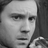

In [6]:
convert_to_img(fer2013.loc[0,'pixels'])

In [7]:
fer2013.loc[:10,'emotion']

0     0
1     0
2     2
3     4
4     6
5     2
6     4
7     3
8     3
9     2
10    0
Name: emotion, dtype: int64

In [8]:
fer2013plus.loc[:10,:]

,Usage,Image name,neutral,happiness,surprise,sadness,anger,disgust,fear,contempt,unknown,NF
0,Training,fer0000000.png,4,0,0,1,3,2,0,0,0,0
1,Training,fer0000001.png,6,0,1,1,0,0,0,0,2,0
2,Training,fer0000002.png,5,0,0,3,1,0,0,0,1,0
3,Training,fer0000003.png,4,0,0,4,1,0,0,0,1,0
4,Training,fer0000004.png,9,0,0,1,0,0,0,0,0,0
5,Training,fer0000005.png,6,0,0,1,0,0,1,1,1,0
6,Training,fer0000006.png,2,0,0,8,0,0,0,0,0,0
7,Training,fer0000007.png,0,10,0,0,0,0,0,0,0,0
8,Training,fer0000008.png,0,10,0,0,0,0,0,0,0,0
9,Training,fer0000009.png,0,0,6,0,0,0,4,0,0,0


# Data Cleaning and Merging

On loading the data, note that the images are pre-segregated into Training, PublicTest (Validation) and PrivateTest (Test) sets. Because Tensorflow's ImageDataGenerator is able to separate training and validation sets on its own, I will merge the training and validation sets together, and let ImageDataGenerator do the splitting.

As noticed, FER+ also introduces additional categories of emotions here, such as contempt, unknown and NF.

As both datasets contain the same number of rows with the same order, I will merge them to get a full view of the classification per image, from each dataset

In [9]:
data = fer2013.merge(fer2013plus, left_index=True, right_index=True)
data.drop(columns='Usage_y', inplace=True)
data.rename(columns={'Usage_x': 'usage'}, inplace=True)
data['usage'] = data['usage'].map({'Training':'train',
                                  'PublicTest':'train',
                                  'PrivateTest':'test'})

The emotion labels in the original FER dataset are numerical. I will change this to their actual emotions for easier reading and interpretation.

In [10]:
data['emotion'] = data['emotion'].map({
    0:'angry', 
    1:'disgust', 
    2:'fear', 
    3:'happy', 
    4:'sad', 
    5:'surprise', 
    6:'neutral'
})

In [11]:
data

,emotion,pixels,usage,Image name,neutral,happiness,surprise,sadness,anger,disgust,fear,contempt,unknown,NF
0,angry,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,train,fer0000000.png,4,0,0,1,3,2,0,0,0,0
1,angry,151 150 147 155 148 133 111 140 170 174 182 15...,train,fer0000001.png,6,0,1,1,0,0,0,0,2,0
2,fear,231 212 156 164 174 138 161 173 182 200 106 38...,train,fer0000002.png,5,0,0,3,1,0,0,0,1,0
3,sad,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,train,fer0000003.png,4,0,0,4,1,0,0,0,1,0
4,neutral,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,train,fer0000004.png,9,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35882,neutral,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,test,fer0035797.png,8,0,0,2,0,0,0,0,0,0
35883,happy,178 174 172 173 181 188 191 194 196 199 200 20...,test,NaN,0,0,0,0,0,0,0,0,0,10
35884,angry,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,test,fer0035799.png,0,0,0,0,7,1,0,2,0,0
35885,happy,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,test,fer0035800.png,0,10,0,0,0,0,0,0,0,0


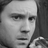

In [12]:
convert_to_img(data.loc[0,'pixels'])

In [13]:
data.loc[[0]]

,emotion,pixels,usage,Image name,neutral,happiness,surprise,sadness,anger,disgust,fear,contempt,unknown,NF
0,angry,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,train,fer0000000.png,4,0,0,1,3,2,0,0,0,0


The emotion classes originally in the FER dataset labels the picture as "angry" in the label `emotion`, but the FER+ classification has a higher probability on the "neutral" emotion instead, which looks to be more accurate as the image doesn't show signs of anger.

I will scale the values in the categories from the FER+ dataset, then use the highest value from the categories in the distribution as the new classification for each of the images and store it as a new column called `new_emotion`.

In [14]:
data['neutral'] = data['neutral'].map(lambda x: x/10)
data['happiness'] = data['happiness'].map(lambda x: x/10)
data['surprise'] = data['surprise'].map(lambda x: x/10)
data['sadness'] = data['sadness'].map(lambda x: x/10)
data['anger'] = data['anger'].map(lambda x: x/10)
data['disgust'] = data['disgust'].map(lambda x: x/10)
data['fear'] = data['fear'].map(lambda x: x/10)
data['contempt'] = data['contempt'].map(lambda x: x/10)
data['unknown'] = data['unknown'].map(lambda x: x/10)
data['NF'] = data['NF'].map(lambda x: x/10)

In [15]:
result = pd.DataFrame(data[['neutral', 'happiness',
       'surprise', 'sadness', 'anger', 'disgust', 'fear', 'contempt',
       'unknown', 'NF']].idxmax(axis=1), columns=['new_emotion'])

In [16]:
data = data.merge(result, left_index=True, right_index=True)

Note that some of the image names in FER+ dataset are empty. Additionally, the unknown and NF images constitutes another 399 records.

In [17]:
data.isnull().sum()

emotion          0
pixels           0
usage            0
Image name     173
neutral          0
happiness        0
surprise         0
sadness          0
anger            0
disgust          0
fear             0
contempt         0
unknown          0
NF               0
new_emotion      0
dtype: int64

In [18]:
data.loc[data['new_emotion'].isin(['unknown','NF'])]

,emotion,pixels,usage,Image name,neutral,happiness,surprise,sadness,anger,disgust,fear,contempt,unknown,NF,new_emotion
17,fear,255 255 255 255 255 255 255 255 255 255 255 25...,train,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NF
23,angry,8 9 14 21 26 32 37 46 52 62 72 70 71 73 76 83 ...,train,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NF
59,fear,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,train,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NF
170,sad,81 79 83 80 80 85 83 77 80 87 90 89 86 83 85 8...,train,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NF
460,fear,200 201 203 204 205 207 207 219 114 27 28 48 7...,train,fer0000459.png,0.1,0.0,0.3,0.1,0.0,0.0,0.1,0.0,0.4,0.0,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35672,fear,169 143 52 69 64 45 42 36 30 29 25 20 45 89 12...,test,fer0035588.png,0.2,0.0,0.0,0.1,0.2,0.0,0.2,0.0,0.3,0.0,unknown
35743,fear,255 255 255 255 255 255 255 255 255 255 255 25...,test,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NF
35795,angry,255 255 254 255 174 139 148 149 153 154 158 16...,test,fer0035710.png,0.2,0.0,0.0,0.0,0.3,0.1,0.0,0.0,0.4,0.0,unknown
35825,sad,243 232 244 255 254 245 244 226 165 166 162 18...,test,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NF


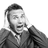

In [19]:
convert_to_img(data.loc[data['new_emotion'].isin(['unknown','NF'])].head(1)['pixels'].values[0])

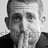

In [20]:
convert_to_img(data.loc[data['new_emotion'].isin(['unknown','NF'])].iloc[[4]]['pixels'].values[0])

On reviewing rows that had `Image name` set as null, and images that might not have been well classified and labelled as 'unknown' or 'NF' under `new_emotion`, I will drop these records.

In [21]:
data = data.loc[~data['Image name'].isnull()]

In [22]:
data.drop(data[data['new_emotion'].isin(['unknown','NF'])].index, inplace=True)

In [23]:
data.reset_index(inplace=True)

Since I won't be using the original `FER2013` dataset's classification of images for the training set, I will drop the `emotion` column too. I don't need the `Image name` column as I will generate filenames for the training images with a different naming convention, based on their category and index.

In [24]:
data.drop(columns=['emotion', 'Image name', 'index'], inplace=True)

Overall looking at the dataset, although there are no heavily skewed data (> 50%), the images under "neutral" emotion constitutes 36% of the total data.

neutral      0.363672
happiness    0.263610
surprise     0.125733
sadness      0.123168
anger        0.087663
fear         0.023078
disgust      0.006988
contempt     0.006087
Name: new_emotion, dtype: float64


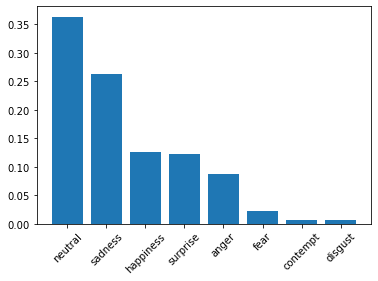

In [25]:
print(data['new_emotion'].value_counts(normalize=True))
plt.bar(x=data['new_emotion'].unique().tolist(), height=data['new_emotion'].value_counts(normalize=True))
plt.xticks(rotation=45);

# Convert pixels to images, save in associated folders

I will create a folder to store the training and test images. Also, I will export our new combined dataset for future purposes.

In [26]:
data.to_csv('./data/newfer.csv')

I then create the train and test image folders, together with each of the categories as subfolders. The subfolders will work well in tandem with Tensorflow's ImageDataGenerator during the modelling phase.

In [27]:
base_path = './data/'
train_path = './data/train/'
test_path = './data/test/'
# validation_path = './images/validation/'

In [28]:
try:
    if ~os.path.exists('./data'):
        os.makedirs(train_path)
        os.makedirs(test_path)
#         os.makedirs(validation_path)
    else:
        if ~os.path.exists(train_path):
            os.makedirs(train_path)
        elif ~os.path.exists(test_path):
            os.makedirs(test_path)
#         elif ~os.path.exists(validation_path):
#             os.makedirs(validation_path)
        else:
            print('No folder creation required')
except:
    print("Error occurred on creation of directory")
    
for emo_class in data['new_emotion'].unique().tolist():
    os.makedirs(train_path + emo_class)
    os.makedirs(test_path + emo_class)
#     os.makedirs(validation_path + emo_class)

For each row in our dataframe `data`, I convert the pixels to an image, and save it into the associated folder of category based on `new_emotion`.

In [29]:
for usage in data['usage'].unique():
    usage_emo = data.loc[data['usage'] == usage, ['pixels','new_emotion']]
    for emo in usage_emo['new_emotion'].unique():
        idx_lst = usage_emo[usage_emo['new_emotion'] == emo].index
        for idx in idx_lst:
            img = convert_to_img(data.loc[idx,'pixels'])
            img_path = base_path + usage + '/' + emo + '/'
            img_name = emo + '_' + str(idx) + '.png'
            img.save(img_path + img_name, format='png')